In [1]:
import pandas as pd
import numpy as np
import os

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
### sns.set_style('darkgrid')

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# # scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer, make_column_transformer
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# # Over-sampling using SMOTE
# from imblearn.over_sampling import SMOTE

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn import tree

import xgboost as xgb
import tensorflow
from tensorflow.keras.models import load_model
import joblib



In [2]:
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential

In [3]:
abt = pd.read_csv("WO_SMOTE_DATA.csv")
print(f"Dataframe dimensions: {abt .shape}")
abt.head()

Dataframe dimensions: (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,1,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,1,0,43,2,125510.82,1,1,1,79084.10,0


In [4]:
abt.Exited.value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [5]:
#Separate dataframe into separate object

# Object for target variable
y = abt.Exited

# object for input features
X = abt.drop(['Exited'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)

(10000, 10) (10000,)


In [6]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [7]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state,
                                                    stratify=abt.Exited)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 8061 to 4741
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7000 non-null   int64  
 1   Geography        7000 non-null   int64  
 2   Gender           7000 non-null   int64  
 3   Age              7000 non-null   int64  
 4   Tenure           7000 non-null   int64  
 5   Balance          7000 non-null   float64
 6   NumOfProducts    7000 non-null   int64  
 7   HasCrCard        7000 non-null   int64  
 8   IsActiveMember   7000 non-null   int64  
 9   EstimatedSalary  7000 non-null   float64
dtypes: float64(2), int64(8)
memory usage: 601.6 KB


In [9]:
AdaBoost_model = joblib.load('ML_MODELS/AdaBoostClassifier_WO_SMOTE_best_model.joblib')
DL_model = joblib.load('ML_MODELS/WO_SMOTE_scikeras.sav')
lr_model = joblib.load('ML_MODELS/LogisticRegression_WO_SMOTE_best_model.joblib')
lgbm_model = joblib.load('ML_MODELS/LGBMClassifier_WO_SMOTE_best_model.joblib')
rf_model = joblib.load('ML_MODELS/RandomForestClassifier_WO_SMOTE_best_model.joblib')
xgb_model = joblib.load('ML_MODELS/XGBClassifier_WO_SMOTE_best_model.joblib')

In [10]:
# Create models dictionary, it will be needed for ploting



models = {
    'lgbm' : 'LGBMClassifier',
    'lr' : 'Logistic Regression',
    'rf' : 'Random Forest',
    'AdaBoost' : 'AdaBoostClassifier',
    'xgb' : 'XGBoost',
    'dl': 'Deep Learning'
}

In [11]:
loaded_models = {
     'lgbm' : lgbm_model,
    'lr' : lr_model,
    'rf' : rf_model,
    'AdaBoost' : AdaBoost_model,
    'xgb' : xgb_model,
     'dl': DL_model 
}

In [12]:
target_names = ['Stays', 'Exits']

In [13]:
def evaluation(fit_models):
    lst = []
    for name, model in fit_models.items():
        pred = model.predict(X_test)
        lst.append([name, 
                    precision_score(y_test, pred, average='macro'),
                    recall_score(y_test, pred, average='macro'),
                    f1_score(y_test, pred, average='macro'),
                    accuracy_score(y_test, pred)])

    eval_df = pd.DataFrame(lst, columns=['model', 'precision', 'recall', 'f1_macro', 'accuracy'])
    eval_df.set_index('model', inplace = True)
    return eval_df

In [14]:
def class_rep_cm(fit_models, models, model_id):
    # Predict classes using model_id
    pred = fit_models[model_id].predict(X_test)
    print()
    print('\t', models[model_id])
    print('\t', '='*len(models[model_id]))

    # Display confusion matrix for y_test and pred
    conf_df = pd.DataFrame(confusion_matrix(y_test, pred), columns=target_names, index=target_names)
    conf_df.index.name = 'True Labels'
    conf_df = conf_df.rename_axis('Predicted Labels', axis='columns')
    display(conf_df)
    
    # Display classification report
    print()
    print(classification_report(y_test, pred, target_names=target_names))

In [15]:
def plot_conf_mat_w_and_wo_norm(fit_models, models, model_id, color):
    # Plot confusion matrix heatmaps
    pred = fit_models[model_id].predict(X_test)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.suptitle(models[model_id], fontsize=14)
    f.subplots_adjust(top=0.85, wspace=0.3)

    # confusion matrix without normalization
    mat = confusion_matrix(y_test, pred)
    sns.heatmap(mat,
                annot=True,
                annot_kws=dict(fontsize=14),
                fmt='d',
                cbar=True,
                square=True,
                cmap=color,
                ax=ax1)

    ax1.set_xticklabels(labels=target_names)
    ax1.set_yticklabels(labels=target_names, va='center')
    ax1.set_title('Confusion Matrix w/o Normalization')
    ax1.set_xlabel('Predicted Label', size=12)
    ax1.set_ylabel('True Label', size=12)

    # normalized confusion matrix
    matn = mat / mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(matn,
                annot=True,
                annot_kws=dict(fontsize=14),
                fmt='.2f',
                cbar=True,
                square=True,
                cmap=color,
                vmin = 0,
                vmax = 1,
                ax=ax2)

    ax2.set_xticklabels(labels=target_names)
    ax2.set_yticklabels(labels=target_names, va='center')
    ax2.set_title('Normalized Confusion Matrix')
    ax2.set_xlabel('Predicted Label', size=12)
    ax2.set_ylabel('True Label', size=12)

    plt.show()

In [16]:
def plot_norm_conf_matrices(fit_models, models, color):
    # Prepare lists of coordinates for axes
    lt = []  # list for full subplots
    ltd = []  # list for empty subplots
    col = 2  # number of columns
    n_mod = len(fit_models)  # number of fitted models
    
    # Number of rows
    row = - (n_mod // -col)
    
    # Create lists of coordinates for full and empty subplots
    for r in range(row):
        for c in range(col):
            if n_mod >= (r + 1) * (c + 1):
                lt.append([r, c])
            else:
                ltd.append([r, c])
    
    # Create figure and subplots
    figs_y = row * 4  # y size
    f, axs = plt.subplots(row, col, figsize=(10, figs_y))
    f.suptitle('Normalized Confusion Matrices Without SMOTE', fontsize=14)
    f.subplots_adjust(top=0.94, wspace=0.90, hspace=0.2)
    
    # Reshape axes; needed in case of only 1 row
    axs = axs.reshape(row,-col)

    # Loop to delete N last empty subplots (if any)
    for n in range(len(ltd)):
        r = ltd[n][0]
        c = ltd[n][1]
        f.delaxes(ax= axs[r, c])
        
    # Loop to plot all full subplots
    i = 0
    # Loop for each fitted model        
    for id, model in fit_models.items():
        pred = model.predict(X_test)
        name = models[id]
        r = lt[i][0]
        c = lt[i][1]
        i += 1
     
        mat = confusion_matrix(y_test, pred)    
        # normalized confusion matrix
        matn = mat / mat.sum(axis=1)[:, np.newaxis]

        ax = axs[r, c]
        sns.heatmap(matn,
                    annot=True,
                    annot_kws=dict(fontsize=14),
                    fmt='.2f',
                    cbar=False,
                    square=True,
                    cmap=color,
                    vmin = 0,
                    vmax = 1,
                    #cbar_kws = {'shrink' : 0.85},
                    ax=ax)
    
        ax.set_xticklabels(labels=target_names)
        ax.set_yticklabels(labels=target_names, va='center')
        ax.set_title(name)
        ax.set_xlabel('Predicted Label', size=12)
        ax.set_ylabel('True Label', size=12)
    plt.savefig("./Figures/CONFUSION_MATRIX_WO_SMOTE_ML_MODELS.png")
    plt.show()

In [17]:
# Display evaluation metrics
evaluation(loaded_models)

c:\Users\mkahs\Repository\Nishat_CHURN\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [21:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\mkahs\Repository\Nishat_CHURN\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [21:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the

,precision,recall,f1_macro,accuracy
model,,,,
lgbm,0.806236,0.721868,0.751164,0.859667
lr,0.603868,0.523411,0.503448,0.789000
rf,0.840929,0.704700,0.743071,0.864333
AdaBoost,0.796442,0.711211,0.740081,0.854333
xgb,0.812308,0.722515,0.753166,0.861667
dl,0.398167,0.500000,0.443310,0.796333


In [18]:
for model in models.keys():
    class_rep_cm(loaded_models, models, model)


	 LGBMClassifier


Predicted Labels,Stays,Exits
True Labels,,
Stays,2280,109
Exits,312,299



              precision    recall  f1-score   support

       Stays       0.88      0.95      0.92      2389
       Exits       0.73      0.49      0.59       611

    accuracy                           0.86      3000
   macro avg       0.81      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000


	 Logistic Regression


Predicted Labels,Stays,Exits
True Labels,,
Stays,2321,68
Exits,565,46



              precision    recall  f1-score   support

       Stays       0.80      0.97      0.88      2389
       Exits       0.40      0.08      0.13       611

    accuracy                           0.79      3000
   macro avg       0.60      0.52      0.50      3000
weighted avg       0.72      0.79      0.73      3000


	 Random Forest


Predicted Labels,Stays,Exits
True Labels,,
Stays,2327,62
Exits,345,266



              precision    recall  f1-score   support

       Stays       0.87      0.97      0.92      2389
       Exits       0.81      0.44      0.57       611

    accuracy                           0.86      3000
   macro avg       0.84      0.70      0.74      3000
weighted avg       0.86      0.86      0.85      3000


	 AdaBoostClassifier


Predicted Labels,Stays,Exits
True Labels,,
Stays,2276,113
Exits,324,287



              precision    recall  f1-score   support

       Stays       0.88      0.95      0.91      2389
       Exits       0.72      0.47      0.57       611

    accuracy                           0.85      3000
   macro avg       0.80      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000


	 XGBoost


Predicted Labels,Stays,Exits
True Labels,,
Stays,2287,102
Exits,313,298



              precision    recall  f1-score   support

       Stays       0.88      0.96      0.92      2389
       Exits       0.74      0.49      0.59       611

    accuracy                           0.86      3000
   macro avg       0.81      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000


	 Deep Learning


Predicted Labels,Stays,Exits
True Labels,,
Stays,2389,0
Exits,611,0



              precision    recall  f1-score   support

       Stays       0.80      1.00      0.89      2389
       Exits       0.00      0.00      0.00       611

    accuracy                           0.80      3000
   macro avg       0.40      0.50      0.44      3000
weighted avg       0.63      0.80      0.71      3000



c:\Users\mkahs\Repository\Nishat_CHURN\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkahs\Repository\Nishat_CHURN\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkahs\Repository\Nishat_CHURN\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

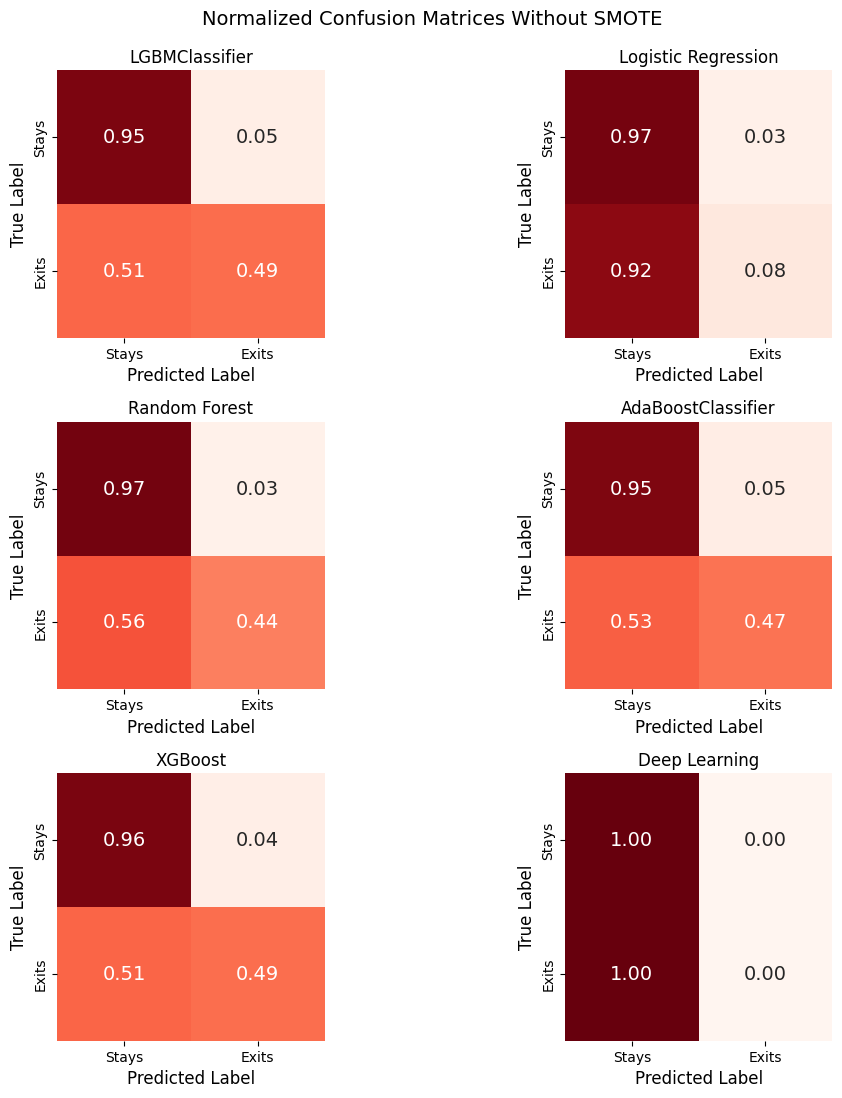

In [19]:
# Plot all confusion matrices 
plot_norm_conf_matrices(loaded_models, models, 'Reds')